# PROPAGANDA CLASSIFICATION WITH PRE-TRAINED LARGE LANGUAGE MODEL - BERT BASE MODEL (UNCASED)

In [1]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Basic imports
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification

In [3]:
# Get data
train_data = pd.read_csv("/content/drive/MyDrive/ee278/ANLP assignment/propaganda_dataset_v2/propaganda_train.tsv", delimiter="\t")
test_data = pd.read_csv("/content/drive/MyDrive/ee278/ANLP assignment/propaganda_dataset_v2/propaganda_val.tsv", delimiter="\t")

# make a copy for task 2
train_data_task2 = train_data.copy()
test_data_task2 = test_data.copy()

In [4]:
# Take a look at dataset
train_data_task2.head()

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [5]:
train_data.sample(5)

,label,tagged_in_context
1410,causal_oversimplification,"On the one hand, <BOS> it knows that those rec..."
345,not_propaganda,take our poll - <BOS> story continues below <E...
1735,"exaggeration,minimisation",She also admits ongoing discussions among thes...
1778,repetition,"One thing we know for sure is that, despite th..."
1714,not_propaganda,"“Lisa” presumably refers to Lisa Gevelber, the..."


In [6]:
print(train_data.shape)
print(test_data.shape)

(2414, 2)
(580, 2)


# TASK 1

In [7]:
# Map the labels to 0 or 1
train_data['label'] = [0 if label=="not_propaganda" else 1 for label in train_data['label']]
test_data['label'] = [0 if label=="not_propaganda" else 1 for label in test_data['label']]

In [8]:
# Get number total number of each label
train_data.groupby('label').count()

,tagged_in_context
label,
0,1191
1,1223


In [9]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize the data
train_tokens = tokenizer.batch_encode_plus(
    train_data["tagged_in_context"].tolist(),
    max_length = 128,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

test_tokens = tokenizer.batch_encode_plus(
    test_data["tagged_in_context"].tolist(),
    max_length = 128,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)


In [10]:
# Convert the tokenized data into PyTorch tensors
train_seq = torch.tensor(train_tokens["input_ids"])
train_mask = torch.tensor(train_tokens["attention_mask"])
train_y = torch.tensor(train_data["label"].tolist())

test_seq = torch.tensor(test_tokens["input_ids"])
test_mask = torch.tensor(test_tokens["attention_mask"])
test_y = torch.tensor(test_data["label"].tolist())

In [11]:
# Create a PyTorch dataset
train_data = TensorDataset(train_seq, train_mask, train_y)
test_data = TensorDataset(test_seq, test_mask, test_y)

# Create a PyTorch data loader
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [12]:
# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set up the optimizer
optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Set up the loss function
loss_fn = torch.nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device(s)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [14]:
# Set the number of epochs
epochs = 4

# Train the model
for epoch in range(epochs):
    # Train the model
    model.train()

    for batch in train_loader:
        b_seq, b_mask, b_labels = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()

        logits = model(b_seq, attention_mask=b_mask)[0]

        loss = loss_fn(logits, b_labels)

        loss.backward()

        optimizer.step()


In [15]:
# Evaluate the model after training on the current epoch
model.eval()

y_pred = []
y_true = []

# Deactivate autograd for evaluation
with torch.no_grad():
    for batch in test_loader:
        b_seq, b_mask, b_labels = tuple(t.to(device) for t in batch)

        logits = model(b_seq, attention_mask=b_mask)[0]

        _, preds = torch.max(logits, dim=1)

        y_pred.extend(preds.tolist())
        y_true.extend(b_labels.tolist())

# Print the classification report
print("Task 1 Accuracy Score - BERT:", accuracy_score(y_true, y_pred))
print("\nTask 1 Classificationtion report - BERT:")
print(classification_report(y_true, y_pred, target_names=["not_propaganda", "propaganda"]))
print("\nTask 1 Confusion Matrix - BERT")
print(confusion_matrix(y_true, y_pred))


Task 1 Accuracy Score - BERT: 0.9310344827586207

Task 1 Classificationtion report - BERT:
                precision    recall  f1-score   support

not_propaganda       0.94      0.92      0.93       301
    propaganda       0.92      0.94      0.93       279

      accuracy                           0.93       580
     macro avg       0.93      0.93      0.93       580
  weighted avg       0.93      0.93      0.93       580


Task 1 Confusion Matrix - BERT
[[278  23]
 [ 17 262]]


Task 1 Confusion Matrix - BERT


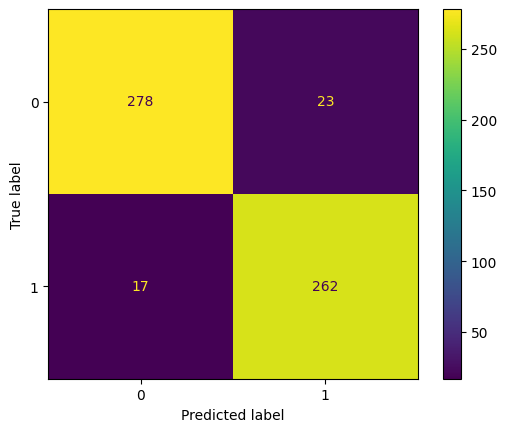

In [16]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
print("Task 1 Confusion Matrix - BERT")
plt.show()

In [17]:
# Save the trained model
torch.save(model.state_dict(), "bert_model.pth")

# Task 2

In [18]:
# Get total number in each label
train_data_task2.groupby('label').count()

,tagged_in_context
label,
appeal_to_fear_prejudice,151
causal_oversimplification,158
doubt,144
"exaggeration,minimisation",164
flag_waving,148
loaded_language,154
"name_calling,labeling",157
not_propaganda,1191
repetition,147


In [19]:
# Encode the labels for task 2 using label encoder
le = LabelEncoder()
train_data_task2["label"] = le.fit_transform(train_data_task2["label"])
test_data_task2["label"] = le.fit_transform(test_data_task2["label"])

In [20]:
train_data_task2.head()

,label,tagged_in_context
0,7,"No, <BOS> he <EOS> will not be confirmed."
1,7,This declassification effort <BOS> won’t make ...
2,4,The Obama administration misled the <BOS> Amer...
3,7,“It looks like we’re capturing the demise of t...
4,7,"<BOS> Location: Westerville, Ohio <EOS>"


In [21]:
# Tokenize the data
train_task2_tokens = tokenizer.batch_encode_plus(
    train_data_task2["tagged_in_context"].tolist(),
    max_length=128,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

test_task2_tokens = tokenizer.batch_encode_plus(
    test_data_task2["tagged_in_context"].tolist(),
    max_length=128,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

In [22]:
# Convert the tokenized data into PyTorch tensors
train_seq2 = torch.tensor(train_task2_tokens["input_ids"])
train_mask2 = torch.tensor(train_task2_tokens["attention_mask"])
train_y2 = torch.tensor(train_data_task2["label"].tolist())

test_seq2 = torch.tensor(test_task2_tokens["input_ids"])
test_mask2 = torch.tensor(test_task2_tokens["attention_mask"])
test_y2 = torch.tensor(test_data_task2["label"].tolist())

In [23]:
# Create a PyTorch dataset
train_dataset = TensorDataset(train_seq2, train_mask2, train_y2)
test_dataset = TensorDataset(test_seq2, test_mask2, test_y2)

# Set the batch size and Create a PyTorch data loader
batch_size = 32
train_sampler = RandomSampler(train_dataset)
test_sampler = RandomSampler(test_dataset)
train_loader2 = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
test_loader2 = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)

In [24]:
len(le.classes_), le.classes_

(9,
 array(['appeal_to_fear_prejudice', 'causal_oversimplification', 'doubt',
        'exaggeration,minimisation', 'flag_waving', 'loaded_language',
        'name_calling,labeling', 'not_propaganda', 'repetition'],
       dtype=object))

In [25]:
# Load the pre-trained BERT model for sequence classification
model2 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels=len(le.classes_),
    output_attentions=False,
    output_hidden_states=False
)

# Set the optimizer and the learning rate
optimizer = torch.optim.Adam(model2.parameters(), lr=2e-5)

# Set up the loss function
loss_fn = torch.nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [26]:
# Put the model on the GPU
device2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")       

model2.to(device2)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [27]:
# Set the number of epochs
epochs = 4

for epoch in range(epochs):
    # Train the model
    model2.train()

    for batch in train_loader2:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()

        logits = model2(b_input_ids, attention_mask=b_input_mask)[0]

        loss = loss_fn(logits, b_labels)

        loss.backward()

        optimizer.step()


In [28]:
# Evaluate the model after training on the current epoch
model2.eval()

# Empty list to store predictions
test_predictions = []
test_labels = []

# Loop over the test data and classify the propaganda technique used
with torch.no_grad():
  for batch in test_loader2:
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

    logits = model2(b_input_ids, attention_mask=b_input_mask)[0]

    preds = torch.argmax(logits, dim=1)

    test_predictions.extend(preds.cpu().numpy())
    test_labels.extend(b_labels.cpu().numpy())

    

In [29]:
# Print the classification report
print("Task 2 Accuracy Score - BERT:", accuracy_score(test_labels, test_predictions))
print("\nTask 2 Classification report - BERT")
print(classification_report(test_labels, test_predictions, target_names = le.classes_)) 
print("\nTask 2 Confusion Matrix - BERT")
print(confusion_matrix(test_labels, test_predictions))

Task 2 Accuracy Score - BERT: 0.6879310344827586

Task 2 Classification report - BERT
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.55      0.28      0.37        43
causal_oversimplification       0.36      0.61      0.45        31
                    doubt       0.59      0.34      0.43        38
exaggeration,minimisation       0.45      0.18      0.26        28
              flag_waving       0.46      0.56      0.51        39
          loaded_language       0.25      0.11      0.15        37
    name_calling,labeling       0.34      0.77      0.48        31
           not_propaganda       0.94      0.96      0.95       301
               repetition       0.32      0.31      0.32        32

                 accuracy                           0.69       580
                macro avg       0.47      0.46      0.43       580
             weighted avg       0.69      0.69      0.67       580


Task 2 Confusion Matrix - BERT
[[ 12  1

Task 2 Confusion Matrix - BERT


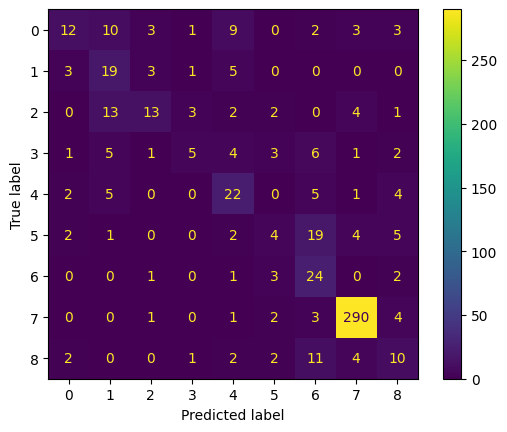

In [30]:
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions)
print("Task 2 Confusion Matrix - BERT")
plt.show()

## REFERENCES

Hugging Face, nd. https://huggingface.co/bert-base-uncased

Sklearn Classification report. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

Sklearn Confusion matrix. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

Sklearn Accuracy. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

Prateek Joshi, nd. https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/